In [6]:
import numpy as np
import pandas as pd
from math import ceil
import matplotlib.pyplot as plt
from monolayer_tracking.utils import *
from scipy.interpolate import LinearNDInterpolator
from pathlib import Path

In [15]:
from cellpose import models, io
from monolayer_tracking.preprocessing import normalize
from scipy.ndimage import gaussian_filter
from monolayer_tracking.preprocessing import gaussian_parallel
from tqdm.notebook import tqdm
from monolayer_tracking import preprocessing
from cellpose import utils
from matplotlib import patheffects
from glob import glob
from natsort import natsorted
from monolayer_tracking.segmented_comprehension import Image

plt.style.use('dark_background')

# write STG from bounding box

In [5]:
input=r"H:\raw_data\20240417 halo FUCCI col_glass SC\tilebounds.STG"
output=None
use_colonies='all'
x_spacing=145
y_spacing=205
padding=50
verbose=True

(-81125.65, -72993.35, 419701.75, 424591.25)

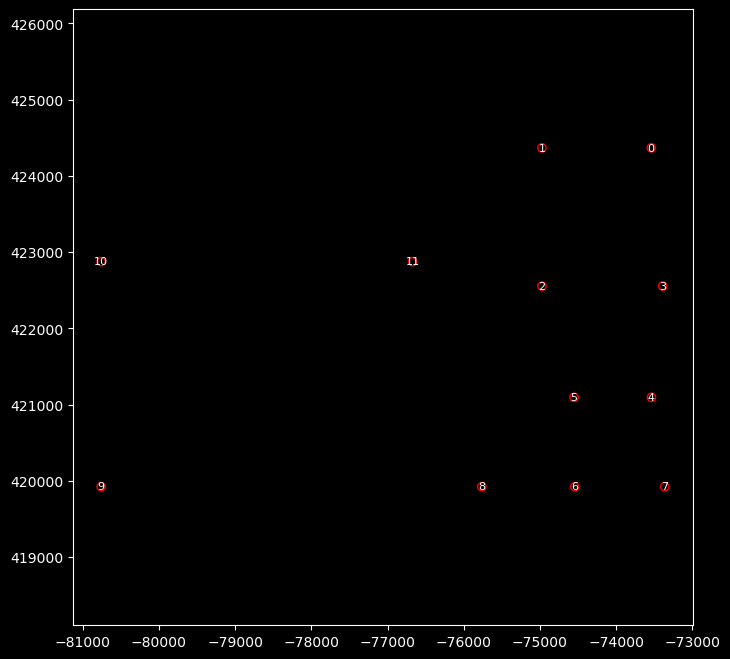

In [6]:
if not output:
    output=input.replace('.STG', '_tiled.STG')

plt.figure(figsize=(8,8))
head, points=read_STG(input)
plt.scatter(points['x'], points['y'], fc='none', ec='r')
for i, txt in enumerate(points.index):
    plt.annotate(txt, (points['x'][i], points['y'][i]), fontsize=8, color='white', ha='center', va='center')

plt.axis('equal')

In [7]:
slide_regions=np.split(points, len(points)/4)

tiled=[]
for n, slide_bounds in enumerate(slide_regions):
    xmin, xmax=slide_bounds['x'].sort_values().iloc[1:3]
    ymin, ymax=slide_bounds['y'].sort_values().iloc[1:3]

    max_corner=pd.Series({'x': xmax, 'y': ymax})
    min_corner=pd.Series({'x': xmin, 'y': ymin})

    z_position=slide_bounds['current_z'].mean()

    tile_centers=grid_from_bbox(min_corner, max_corner, x_spacing, y_spacing, padding)

    # Assign z positions, etc. to each stage position via interpolation
    interpolator=LinearNDInterpolator(slide_bounds[['x', 'y']], slide_bounds[['current_z','AF_offset']])
    z, AF=interpolator(tile_centers[['x', 'y']]).T
    tile_centers['current_z']=np.round(z,2)
    tile_centers['starting_z']=tile_centers['current_z']
    tile_centers['AF_offset']=AF.astype(int)
    tile_centers['position']=f'Region{n+1}'
    tile_centers['stage_number']=[f'_{i}' for i in range(1, len(tile_centers)+1)]
    tile_centers[['FALSE','-9999', 'TRUE_1', 'TRUE_2', '0', '-1', 'endline']]=np.array(slide_bounds[['FALSE', '-9999', 'TRUE_1', 'TRUE_2', '0', '-1', 'endline']])[0]
    tiled.append(tile_centers)
    
tiled=pd.concat(tiled)

c:\Users\Andy\anaconda3\envs\cellpose\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


524


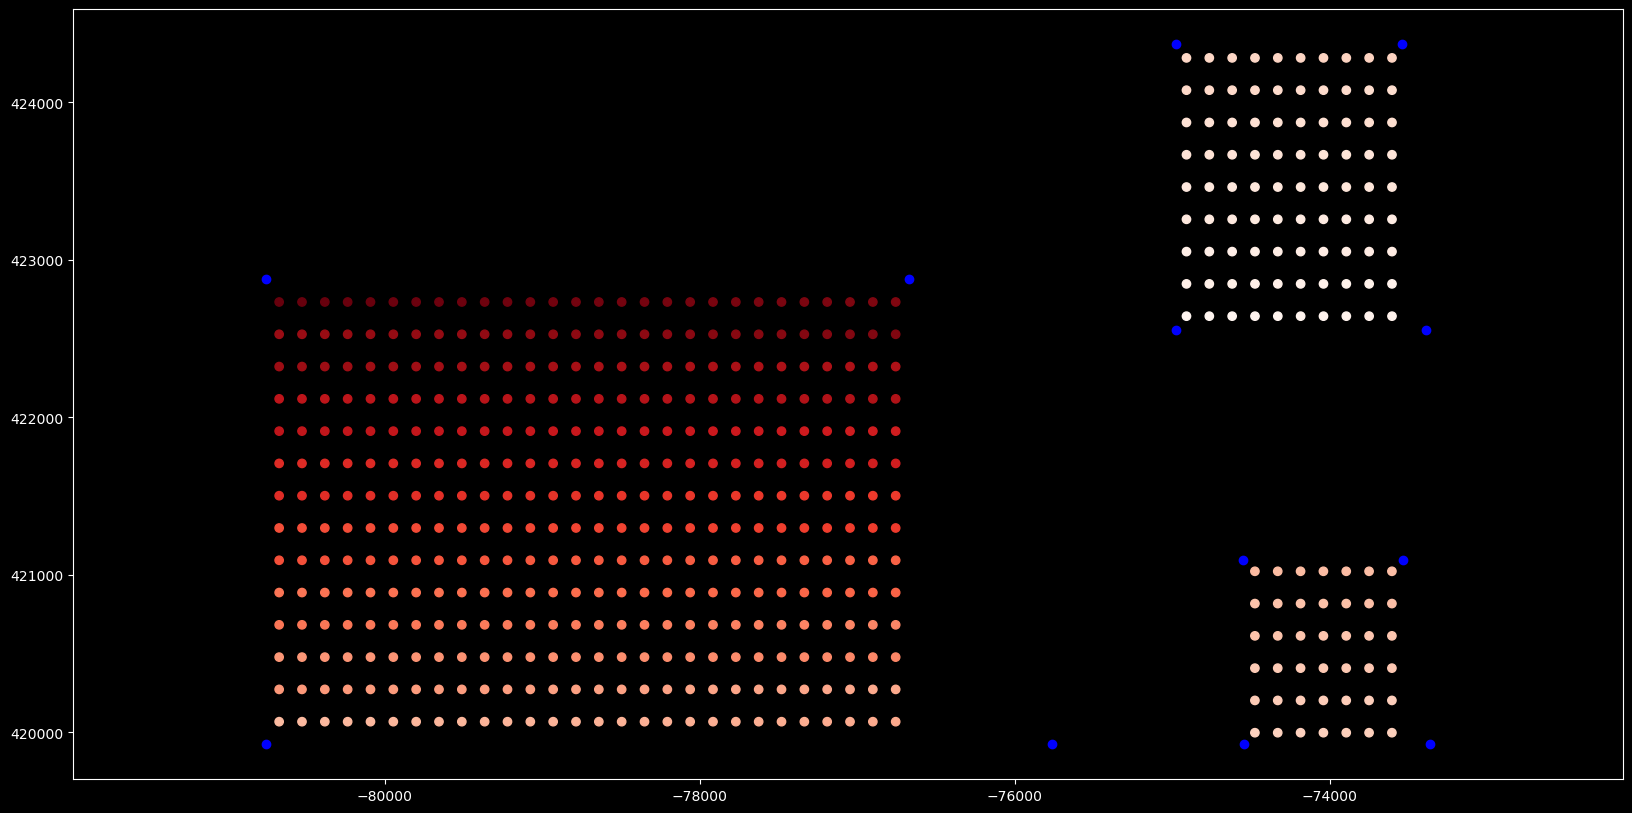

In [8]:
plt.figure(figsize=(20,10))
plt.scatter(tiled['x'], tiled['y'], c=range(len(tiled)), cmap='Reds')
#for i, txt in enumerate(tiled.index):
#    plt.annotate(txt, (tiled['x'][i], tiled['y'][i]))
plt.scatter(points['x'], points['y'], c='b')
plt.axis('equal')
print(len(tiled))

In [9]:
tiled['position']=tiled['position']+tiled['stage_number'] # unique name for each stage position
tiled=tiled[points.columns] # reorder columns for exportingtiled
head[-1]=f'{len(tiled)}\n'
write_STG(output, head, tiled)

# segment

In [49]:
# my mosaic data
imgs=io.imread(r'F:\my_data\Data\20240413 FUCCI_halo_40x suspension\SC_RGB.tif')
model=models.CellposeModel(gpu=True, model_type='cyto3')
diameter=80
output_path=r'F:\my_data\Segmentation\20240413 FUCCI halo suspension\segmented\SC/'
Path(output_path).mkdir(exist_ok=True, parents=True)

for i, img in enumerate(tqdm(imgs)):
    masks=model.eval(img[2], diameter=diameter)[0]
    masks=utils.remove_edge_masks(masks)
    outlines=utils.masks_to_outlines(masks)
    outlines_list=utils.outlines_list(masks)
    export={'img':img, 'masks':masks, 'outlines':outlines, 'outlines_list':outlines_list}
    np.save(output_path+f'SC_{i}.npy', export)

  0%|          | 0/700 [00:00<?, ?it/s]

In [92]:
img

array([[[ 24,  28,  13, ...,  14,   9,  14],
        [  6,   9,  10, ...,  19,   8,  21],
        [ 22,  16,  12, ...,  29,  23,  16],
        ...,
        [ 25,  28,  14, ..., 580, 127,  44],
        [ 10,  19,  18, ..., 119,  47,  32],
        [  5,  10,  19, ...,  55,  25,  13]],

       [[ 18,  50,  88, ...,  77,  50,  34],
        [ 53,  18,  86, ...,  29,  20,  65],
        [ 61,  75,  44, ...,  62,  79,  57],
        ...,
        [124, 119,  63, ...,  57,  31,  13],
        [111,  60,  42, ...,  88,  39,  80],
        [ 98,  43,  61, ..., 115,  59,  94]],

       [[  7,  13,  20, ...,  22,  31,   8],
        [ 29,  23,  21, ...,  47,  21,  55],
        [ 27,  31,  20, ...,  14,  12,  21],
        ...,
        [ 36,  36,  13, ...,  34,  22,  48],
        [ 45,  32,  33, ...,  53,  11,  15],
        [ 24,  56,  28, ...,  19,  50,  39]]], dtype=uint16)

In [93]:
folders=natsorted(glob(r'F:\Heather\FUCCI\suspended\20240419\split\*'))
output_path=r'F:\Heather\FUCCI\suspended\20240419\segmented/'
Path(output_path).mkdir(exist_ok=True, parents=True)
model=models.CellposeModel(gpu=True, model_type='cyto3')
diameter=23

for treatment in tqdm(folders, desc='treatment'):
    files=natsorted(glob(treatment+'/*/*.tif'))
    stem=Path(treatment).stem
    for i, img_path in enumerate(tqdm(files, desc=stem)):
        output_folder=Path(img_path.replace('split','segmented')).parent
        output_folder.mkdir(exist_ok=True, parents=True)
        img=io.imread(img_path)
        img=np.array([img[1], img[2], img[0]]) # re-order channels
        masks=model.eval(img[2], diameter=diameter)[0]
        masks=utils.remove_edge_masks(masks)
        outlines=utils.masks_to_outlines(masks)
        outlines_list=utils.outlines_list(masks)
        export={'img':img, 'masks':masks, 'outlines':outlines, 'outlines_list':outlines_list}

        np.save(output_folder/f'{stem}-{i}_seg.npy', export)

treatment:   0%|          | 0/6 [00:00<?, ?it/s]

Notreatment:   0%|          | 0/15 [00:00<?, ?it/s]

PND:   0%|          | 0/30 [00:00<?, ?it/s]

bum:   0%|          | 0/30 [00:00<?, ?it/s]

rapamycin:   0%|          | 0/30 [00:00<?, ?it/s]

sch77:   0%|          | 0/30 [00:00<?, ?it/s]

ycomp:   0%|          | 0/30 [00:00<?, ?it/s]

# analyze

## get volumes

In [58]:
seg_files=natsorted(glob(r'F:\Heather\FUCCI\suspended\20240419\segmented\Notreatment\dish1'+'/*.npy'))

In [21]:
from scipy import ndimage

In [59]:
seg_files

['F:\\Heather\\FUCCI\\suspended\\20240419\\segmented\\Notreatment\\dish1\\Notreatment-0_seg.npy',
 'F:\\Heather\\FUCCI\\suspended\\20240419\\segmented\\Notreatment\\dish1\\Notreatment-1_seg.npy',
 'F:\\Heather\\FUCCI\\suspended\\20240419\\segmented\\Notreatment\\dish1\\Notreatment-2_seg.npy',
 'F:\\Heather\\FUCCI\\suspended\\20240419\\segmented\\Notreatment\\dish1\\Notreatment-3_seg.npy',
 'F:\\Heather\\FUCCI\\suspended\\20240419\\segmented\\Notreatment\\dish1\\Notreatment-4_seg.npy',
 'F:\\Heather\\FUCCI\\suspended\\20240419\\segmented\\Notreatment\\dish1\\Notreatment-5_seg.npy',
 'F:\\Heather\\FUCCI\\suspended\\20240419\\segmented\\Notreatment\\dish1\\Notreatment-6_seg.npy',
 'F:\\Heather\\FUCCI\\suspended\\20240419\\segmented\\Notreatment\\dish1\\Notreatment-7_seg.npy',
 'F:\\Heather\\FUCCI\\suspended\\20240419\\segmented\\Notreatment\\dish1\\Notreatment-8_seg.npy',
 'F:\\Heather\\FUCCI\\suspended\\20240419\\segmented\\Notreatment\\dish1\\Notreatment-9_seg.npy',
 'F:\\Heather\\FUCCI

In [37]:
frame=Image(seg_files[-3], scale=0.6905357, load_img=True)
red=frame.img[0]
green=frame.img[1]
membrane=frame.img[2]

red=normalize(ndimage.gaussian_filter(red, 3))
green=normalize(ndimage.gaussian_filter(green, 3))

In [38]:
red_threshold=0.2
green_threshold=0.2

thresholded_red=red>red_threshold
thresholded_green=green>green_threshold
thresholded_orange=(red>red_threshold*1.5)&thresholded_green

In [105]:
class SuspendedDataset:
    def __init__(self, path, scale=0.16125, preprocess_FUCCI=True, blur_sigma=5, **kwargs):
        self.name=path
        self.frame_paths=natsorted(glob(path+'/*.npy'))
        self.frames=[Image(frame_path, frame_number=n, scale=scale, load_img=True, **kwargs) for n, frame_path in enumerate(tqdm(self.frame_paths, desc='loading images'))]
        self.scale=scale

        red, green, membrane=[],[],[]
        for frame in self.frames:
            red.append(frame.img[0])
            green.append(frame.img[1])
            membrane.append(frame.img[2])
        self.red=np.array(red)
        self.green=np.array(green)
        self.membrane=np.array(membrane)

        if preprocess_FUCCI:
            self.red, self.green=self._normalize_FUCCI(*self._blur_FUCCI(blur_sigma))

    def _blur_FUCCI(self, sigma=5):
        red=gaussian_parallel(self.red, sigma=sigma, progress_bar=tqdm)
        green=gaussian_parallel(self.green, sigma=sigma, progress_bar=tqdm)
        return np.array(red), np.array(green)
    
    def _normalize_FUCCI(self, red, green):
        red=normalize(red.flatten()).reshape(red.shape)
        green=normalize(green.flatten()).reshape(green.shape)
        return red, green

    def measure_FUCCI(self, red_threshold=0.3, green_threshold=0.3, orange_brightness=1.5, percent_threshold=0.15):
        thresholded_red=self.red>red_threshold
        thresholded_green=self.green>green_threshold
        thresholded_orange=(self.red>red_threshold*orange_brightness)&thresholded_green # orange cells have to be bright red
        self.red_threshold=red_threshold
        self.green_threshold=green_threshold

        cc_stages=preprocessing.parallel_frame_FUCCI(list(zip([frame.masks for frame in self.frames], thresholded_red, thresholded_green, thresholded_orange)), progress_bar=tqdm, percent_threshold=percent_threshold)
        self.cc_stages=cc_stages
        return self.cc_stages
    
    def get_outlines(self, progress_bar=tqdm):
        from multiprocessing import Pool

        if progress_bar is None:
            progress_bar=lambda x: x
            progress_kwargs={}
        else:
            progress_kwargs={'total':len(self.frames),'desc':'Getting outlines'}
        p=Pool(8)
        self.outlines=[x for x in progress_bar(p.imap(utils.outlines_list, [frame.masks for frame in self.frames]), **progress_kwargs)]
        return self.outlines
    
    def get_volumes(self, circ_threshold=0.85):
        if not hasattr(self, 'cc_stages'):
            self.measure_FUCCI()
        if not hasattr(self, 'outlines'):
            self.get_outlines()
        
        all_outlines=[outline for outlines in self.outlines for outline in outlines]
        all_cc_stages=np.concatenate(self.cc_stages)

        circs=np.array([polyCircularity(*np.array(outline).T) for outline in all_outlines])
        circular_outlines=[all_outlines[i] for i in np.where(circs>circ_threshold)[0]]
        circular_cc=[all_cc_stages[i] for i in np.where(circs>circ_threshold)[0]]

        volumes=[]
        for stage in tqdm(range(4), desc='Calculating volumes'):
            volumes.append(np.array([polyVolume(*np.array(outline).T) for i, outline in enumerate(circular_outlines) if circular_cc[i]==stage])*self.scale**3)
        self.volumes=volumes
        return self.volumes
    
    def show_FUCCI(self, idx, circ_threshold=0.85):
        plt.imshow(np.stack([self.red[idx], self.green[idx], np.zeros_like(self.red[idx])], axis=-1))
        
        # annotate cell numbers
        if not hasattr(self, 'cc_stages'):
            self.measure_FUCCI()
        if not hasattr(self, 'outlines'):
            self.get_outlines()

        cc_stages=self.cc_stages[idx]
        outlines=utils.outlines_list(self.frames[idx].masks)
        colors=['white','g','r','orange']
        for i, (cell_number, cc, o) in enumerate(zip(np.unique(self.frames[idx].masks)[1:], cc_stages, outlines)):
            if polyCircularity(*np.array(o).T)<circ_threshold:
                plt.plot(*o.T, c='gray', lw=0.5)
                continue
            #centroid=np.mean(np.argwhere(self.frames[idx].masks==cell_number), axis=0)
            plt.plot(*o.T, c=colors[cc], lw=0.5)
            # outline text
            #label=plt.text(*centroid[::-1], f'{cc}', ha='center', va='center', fontsize=8, color='w')
            #label.set_path_effects([patheffects.withStroke(linewidth=1, foreground='black')])
    
    def __len__(self):
        return len(self.frames)
    
    def __getitem__(self, idx):
        return self.frames[idx]
    
def polyPerimeter(x,y):
    return np.sum(np.sqrt(np.diff(x)**2+np.diff(y)**2)) 

def polyCircularity(x,y):
    return 4*np.pi*polyArea(x,y)/polyPerimeter(x,y)**2

def polyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def volume_from_area(area):
    # spherical volume from circular area
    return 4/3*np.pi*(area/np.pi)**1.5

def polyVolume(x,y):
    return volume_from_area(polyArea(x,y))

In [ ]:
WT=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\Notreatment\dish1', scale=0.6905357, blur_sigma=2)
bum1=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\bum\dish1', scale=0.6905357, blur_sigma=2)
bum2=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\bum\dish2', scale=0.6905357, blur_sigma=2)
PND1=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\PND\dish1', scale=0.6905357, blur_sigma=2)
PND2=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\PND\dish2', scale=0.6905357, blur_sigma=2)
rapamycin1=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\rapamycin\dish1', scale=0.6905357, blur_sigma=2)
rapamycin2=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\rapamycin\dish2', scale=0.6905357, blur_sigma=2)
sch771=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\sch77\dish1', scale=0.6905357, blur_sigma=2)
sch772=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\sch77\dish2', scale=0.6905357, blur_sigma=2)
ycomp1=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\ycomp\dish1', scale=0.6905357, blur_sigma=2)
ycomp2=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\ycomp\dish2', scale=0.6905357, blur_sigma=2)

In [6]:
SC_0413=SuspendedDataset(r'F:\my_data\Segmentation\20240413 FUCCI halo suspension\segmented\SC')

loading images:   0%|          | 0/700 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/700 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/700 [00:00<?, ?it/s]

In [7]:
ME_0413=SuspendedDataset(r'F:\my_data\Segmentation\20240413 FUCCI halo suspension\segmented\ME')

loading images:   0%|          | 0/700 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/700 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/700 [00:00<?, ?it/s]

In [ ]:
Heather_SC=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240410\segmented/', scale=0.3452677)

In [ ]:
SC_0407=SuspendedDataset(r'F:\my_data\Segmentation\20240407 FUCCI suspension\segmented\SC/')

In [ ]:
SC_0411=SuspendedDataset(r'F:\my_data\Segmentation\20240411 FUCCI suspension\segmented\SC/')

In [ ]:
ME_0412=SuspendedDataset(r'F:\my_data\Segmentation\20240412 FUCCI_halo_40x suspension ME\segmented\ME/')

In [ ]:
#ME2_0415=SuspendedDataset(r'F:\my_data\Segmentation\20240415 halo FUCCI col_glass ME adhered_suspended\segmented\suspension2/')
ME1_0415=SuspendedDataset(r'F:\my_data\Segmentation\20240415 halo FUCCI col_glass ME adhered_suspended\segmented\suspension1/')

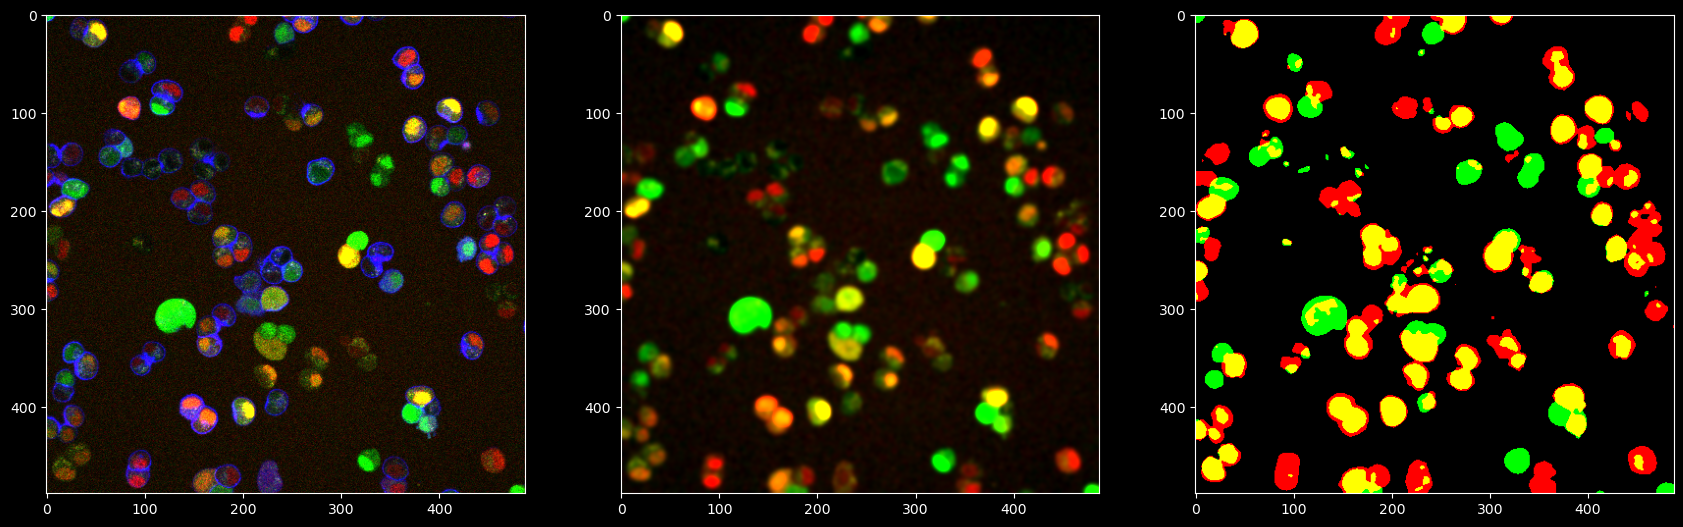

In [112]:
n=-10
to_plot=bum1

fig, axes=plt.subplots(1,3, figsize=(21,20))
axes[0].imshow(preprocessing.normalize(to_plot.frames[n].img.transpose(1,2,0)))

color_FUCCI=np.stack([to_plot.red[n], to_plot.green[n], np.zeros_like(to_plot.red[n])], axis=-1)
axes[1].imshow(color_FUCCI)

threshold_FUCCI=np.stack([to_plot.red[n]>0.15, to_plot.green[n]>0.2, np.zeros_like(to_plot.red[n])], axis=-1)
axes[2].imshow(threshold_FUCCI)

In [ ]:
for dataset in [WT, bum1, bum2, PND1, PND2, rapamycin1, rapamycin2, sch771, sch772, ycomp1, ycomp2]:
    dataset.measure_FUCCI(red_threshold=0.15, green_threshold=0.2, orange_brightness=1.5, percent_threshold=0.15)
    dataset.get_volumes()

In [121]:
WT_vols=WT.volumes
bum1_vols=[np.concatenate([v1, v2]) for v1, v2 in zip(bum1.volumes, bum2.volumes)]
PND_vols=[np.concatenate([v1, v2]) for v1, v2 in zip(PND1.volumes, PND2.volumes)]
rapamycin_vols=[np.concatenate([v1, v2]) for v1, v2 in zip(rapamycin1.volumes, rapamycin2.volumes)]
sch77_vols=[np.concatenate([v1, v2]) for v1, v2 in zip(sch771.volumes, sch772.volumes)]
ycomp_vols=[np.concatenate([v1, v2]) for v1, v2 in zip(ycomp1.volumes, ycomp2.volumes)]

In [102]:
WT.measure_FUCCI(red_threshold=0.15, green_threshold=0.2, orange_brightness=1.5, percent_threshold=0.15)

Processing frames:   0%|          | 0/15 [00:00<?, ?it/s]

[array([1, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 3, 2,
        0, 0, 1, 1, 2, 1, 1, 0, 2, 2, 3, 1, 2, 2, 1, 0, 2, 1, 2, 0, 0, 0,
        2, 2, 2, 3, 2, 1, 0, 1, 2, 1, 2, 2, 2, 2, 0, 1, 2, 1, 0, 2, 2, 1,
        1, 2, 1, 2, 2, 0, 0, 1, 1, 0, 1, 2, 2, 1, 2, 2, 1, 0, 1, 1, 0, 2,
        2, 2, 0, 1, 1, 2, 0, 0, 2, 1, 0, 1, 3, 2, 2, 2, 2, 2, 0, 2, 1, 2,
        2, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 2, 0, 3, 3, 3, 1, 1, 2, 3, 2, 3,
        2, 3, 1, 3, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0,
        1, 2, 0, 0, 0, 0, 2, 1, 1, 1, 1, 0, 0, 0, 0, 2, 1, 1, 0, 2, 2, 2,
        0, 2, 2, 1, 1, 3, 2, 3, 2, 1, 2, 2, 0, 3, 1, 2, 2, 2, 1, 1, 2, 2,
        0, 3, 0, 1, 1, 3, 0, 0, 2, 3, 1, 2, 2, 2, 2, 0, 2, 2, 1, 0, 3],
       dtype=int64),
 array([2, 2, 2, 3, 1, 1, 2, 2, 2, 0, 2, 2, 2, 0, 3, 3, 2, 0, 2, 0, 0, 2,
        2, 2, 2, 0, 0, 3, 2, 2, 2, 2, 0, 0, 2, 2, 2, 1, 2, 2, 1, 2, 2, 0,
        2, 0, 0, 1, 1, 1, 2, 2, 0, 2, 2, 1, 3, 1, 3, 2, 1, 1, 3, 2, 1, 3,
        0, 0, 2, 2,

In [17]:
ME_0413.measure_FUCCI(red_threshold=0.5, green_threshold=0.25, orange_brightness=1.5, percent_threshold=0.15)

Processing frames:   0%|          | 0/700 [00:00<?, ?it/s]

[array([1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 3, 0, 1, 1, 3, 1, 1, 1, 1,
        3, 1, 0, 2, 2, 1, 1, 0], dtype=int64),
 array([1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0],
       dtype=int64),
 array([0, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 1, 1, 1, 1],
       dtype=int64),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1], dtype=int64),
 array([1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 2, 2, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 2, 0, 3], dtype=int64),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
       dtype=int64),
 array([0, 1, 0, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 3,
        1, 1, 1, 1, 2, 1, 1], dtype=int64),
 array([0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 0, 0,
        1], dtype=int64),
 array([0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 1, 0], dtype=int64),
 array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1,

In [12]:
SC_0413.measure_FUCCI(red_threshold=0.25, green_threshold=0.25, orange_brightness=1.5, percent_threshold=0.15)

Processing frames:   0%|          | 0/700 [00:00<?, ?it/s]

[array([0, 0, 3, 3, 1, 3, 3, 2, 1, 2, 3, 1, 3, 3, 0, 3, 1, 1, 1, 0, 3, 1,
        0], dtype=int64),
 array([0, 2, 1, 2, 1, 0, 0, 1, 2, 3, 1, 1, 3, 3, 2, 2, 2, 3, 2, 0, 1, 0,
        1, 1, 1, 0], dtype=int64),
 array([1, 2, 2, 2, 3, 2, 2, 3, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 0,
        0, 0, 3, 2, 1, 1, 2, 1], dtype=int64),
 array([0, 2, 2, 0, 2, 2, 3, 0, 3, 1, 2, 1, 1, 3, 0, 2, 2, 1, 1, 3, 3, 2,
        2, 1, 1, 2, 2, 1, 2, 0, 1, 1, 1, 3, 1, 2, 1, 0, 0], dtype=int64),
 array([0, 0, 0, 3, 3, 3, 3, 2, 1, 3, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 0, 0,
        0], dtype=int64),
 array([2, 2, 2, 3, 2, 0, 2, 2, 0, 0, 2, 2, 3, 2, 2, 3, 1, 1, 1, 1, 1, 3,
        1, 2, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 2, 0, 3, 2, 0, 2, 0, 0],
       dtype=int64),
 array([1, 0, 0, 1, 2, 2, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1,
        3, 3, 2, 1, 3, 3, 3, 0, 2, 1, 1, 1, 1, 3, 0, 0, 1, 0], dtype=int64),
 array([0, 1, 3, 3, 0, 3, 3, 0, 0, 2, 0, 2, 1, 3, 0, 0, 2, 1, 1, 2, 3, 3,
        3, 2, 2, 2, 3, 2, 2

In [9]:
ME1_0415.measure_FUCCI(red_threshold=0.2, green_threshold=0.2, orange_brightness=1.5, percent_threshold=0.15)

Processing frames:   0%|          | 0/859 [00:00<?, ?it/s]

[array([0, 1, 1, 2, 0, 3, 0, 1, 1, 1, 1, 2, 1, 3, 2, 1, 1, 1, 3, 1, 3, 1,
        1, 3, 1, 1, 3, 3, 1, 3, 1, 1, 0, 1, 1, 2, 1, 2], dtype=int64),
 array([1, 2, 3, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 3, 1, 1, 1, 2, 2,
        2, 1, 1, 3], dtype=int64),
 array([1, 1, 1, 2, 1, 3, 1, 2, 3, 0, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 2, 1,
        2, 1, 1, 1, 2], dtype=int64),
 array([1, 0, 2, 1, 1, 1, 3, 1, 3, 1, 3, 1, 3, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        1], dtype=int64),
 array([3, 1, 1, 1, 1, 1, 0, 1, 1, 1, 3, 0, 3, 1, 2, 3, 1, 1, 0, 2, 1, 1,
        1, 1, 3, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1], dtype=int64),
 array([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 0, 2, 2, 3,
        3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1], dtype=int64),
 array([2, 1, 0, 2, 2, 1, 1, 2, 1, 0, 1, 1, 1, 2, 2, 1, 2, 3, 1, 1, 2, 1,
        2, 1, 1, 1, 1], dtype=int64),
 array([2, 0, 1, 2, 0, 3, 1, 1, 1, 0, 1, 1, 1, 3, 1, 1, 1, 3, 2, 3, 3, 3,
        1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 0, 1, 2, 1, 1, 1, 3,

In [6]:
ME_0412.measure_FUCCI(red_threshold=0.2, green_threshold=0.2, orange_brightness=1.5, percent_threshold=0.15)

Processing frames:   0%|          | 0/660 [00:00<?, ?it/s]

[array([2, 0, 1, 2, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0,
        1, 2, 1, 1, 0, 1, 1, 2, 3, 1, 0, 2, 2, 1, 1, 2, 1, 0, 2, 1, 1, 1,
        1, 1, 1, 2, 1, 1, 1, 2, 2, 0, 2, 1], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0],
       dtype=int64),
 array([1, 1, 1, 1, 1, 2, 1, 0, 2, 1, 3, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 2, 1, 0, 2, 1, 1, 1, 1, 1, 2, 1,
        0, 1, 0, 1, 2, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1], dtype=int64),
 array([2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 2, 0, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1,
        1], dtype=int64),
 array([0, 0, 1, 2, 1, 2, 2, 0, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 0, 2, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1,
        1, 

In [7]:
SC_0411.measure_FUCCI(red_threshold=0.1, green_threshold=0.2, orange_brightness=2.25, percent_threshold=0.15)

Processing frames:   0%|          | 0/725 [00:00<?, ?it/s]

[array([0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 3, 2, 3, 2, 3, 1,
        1, 2, 2, 2, 2, 1, 3, 2, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
        2, 1, 1, 0], dtype=int64),
 array([0, 0, 2, 2, 1, 1, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 1, 2, 3, 2, 1, 2,
        2, 0, 0, 1, 2, 1, 2, 2, 2, 0, 0, 2, 2, 2, 2], dtype=int64),
 array([2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 1, 1, 2,
        2, 3, 3, 1, 0, 2, 2], dtype=int64),
 array([2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 1, 0, 2, 2, 2, 1, 2, 0, 1, 2, 1, 2,
        2, 2, 2, 3, 2, 2, 3, 2, 2, 0, 2, 1, 0, 2, 2, 0], dtype=int64),
 array([2, 2, 2, 0, 0, 2, 2, 2, 2, 1, 3, 1, 3, 0, 1, 2, 1, 1, 2, 1, 2, 1,
        2, 3, 1, 2, 1, 2, 2, 2, 2, 3, 2, 3, 1, 0, 2, 1], dtype=int64),
 array([1, 3, 2, 2, 2, 2, 1, 0, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1,
        1, 0, 1, 2, 3, 1, 1, 1, 1, 3, 3, 2, 1, 0, 2, 1, 2, 0, 0, 2, 2, 2,
        1], dtype=int64),
 array([1, 1, 2, 1, 3, 3, 2, 2, 0, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2,
        2, 1, 1, 1,

In [19]:
Heather_SC.measure_FUCCI(red_threshold=0.5, green_threshold=0.2, percent_threshold=0.15)

Processing frames:   0%|          | 0/11 [00:00<?, ?it/s]

[array([1, 0, 1, 1, 0, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 1, 1, 1, 0, 1, 2, 0, 1, 1, 0, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1,
        3, 1, 1, 1, 0, 1, 1, 1, 3, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 0, 2, 0, 3, 3, 3, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 3, 1, 0, 1, 1, 2, 1,
        3, 0, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 3, 3, 2, 1, 0, 1, 1, 2, 1, 1,
        1, 1, 1, 0, 1, 3, 2, 1, 2, 2, 1, 0, 1, 1, 0, 1, 2, 0, 1, 0, 1, 0,
        1, 1, 1, 3, 1, 1, 0, 3, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 2, 1,
        1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 1, 0, 2, 0, 1, 1,
        1, 2, 1, 2, 3, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 3,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 2, 3, 0, 1, 1, 1, 1, 1, 1, 1,
        1], dtype=int64),
 array([0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 3, 0, 1, 3, 0, 0, 2, 0, 2, 1, 0, 2,
        0, 0

In [24]:
SC_0407.measure_FUCCI(red_threshold=0.25, green_threshold=0.2, percent_threshold=0.2)
pass

Processing frames:   0%|          | 0/525 [00:00<?, ?it/s]

In [8]:
ME.measure_FUCCI(red_threshold=0.7, green_threshold=0.2, percent_threshold=0.2)
pass

Processing frames::   0%|          | 0/420 [00:00<?, ?it/s]

In [120]:
SC_new.measure_FUCCI(red_threshold=0.5, green_threshold=0.45, percent_threshold=0.2)

Processing frames::   0%|          | 0/82 [00:00<?, ?it/s]

[array([1, 1, 2, 1, 3, 3, 3, 1, 3, 2, 3], dtype=int64),
 array([3, 3, 2, 0, 2, 1, 0, 2, 2, 3, 1, 2], dtype=int64),
 array([1, 2, 1, 2, 3, 2, 1], dtype=int64),
 array([0, 0, 2, 0, 2, 1, 1, 1, 2, 1, 0, 1, 3], dtype=int64),
 array([2, 1, 3, 3, 2, 1, 1, 3, 0, 1, 0, 1], dtype=int64),
 array([2, 3, 1, 1, 3, 2, 3, 3, 3, 2, 3, 3, 2], dtype=int64),
 array([3, 3, 1, 1, 2, 3, 0, 3, 0, 3, 1, 1, 2], dtype=int64),
 array([2, 0, 1, 1, 2, 1, 0, 0, 1, 0], dtype=int64),
 array([0, 3, 0, 2, 1, 3, 2, 0, 3, 2, 1, 1, 3, 3, 2, 1], dtype=int64),
 array([0, 2, 1, 3, 3, 2, 3, 0, 1, 3], dtype=int64),
 array([0, 2, 2, 1, 3, 3, 2, 0, 1], dtype=int64),
 array([2, 0, 0, 2, 3, 1, 1, 1, 1, 0, 0], dtype=int64),
 array([3, 3, 1, 2, 1, 2, 2, 0, 1, 3, 1, 0, 2, 2, 3, 0], dtype=int64),
 array([2, 2, 1, 3, 0, 1, 2, 1, 3, 0, 1, 1, 0, 2], dtype=int64),
 array([2, 2, 3, 3, 2, 3, 2, 3, 3, 1, 2, 0, 2], dtype=int64),
 array([0, 2, 3, 3, 3, 1, 2, 1], dtype=int64),
 array([0, 1, 2, 0, 3, 3, 3, 2, 0, 1], dtype=int64),
 array([0, 1, 2

In [253]:
help(to_plot.show_FUCCI)

Help on method show_FUCCI in module __main__:

show_FUCCI(idx, circ_threshold=0.85) method of __main__.SuspendedDataset instance



In [259]:
PND

'F:\\Heather\\FUCCI\\suspended\\20240419\\segmented\\bum\\dish2\\bum-15_seg.npy'

In [268]:
# export FUCCI labels for verification
to_plot=ycomp2
for n in tqdm(range(len(to_plot.frames)), desc='drawing frame'):
    fig=plt.figure(figsize=(10,5))
    ax_0=fig.add_subplot(121)
    to_plot.show_FUCCI(n)
    ax_0.set_title('segmented and labeled FUCCI')
    ax_1=fig.add_subplot(122)
    ax_1.imshow(np.stack([to_plot.red[n]>to_plot.red_threshold, to_plot.green[n]>to_plot.green_threshold, np.zeros_like(to_plot.red[n])], axis=-1))
    ax_1.set_title('binarized')
    plt.savefig(r'F:\Heather\FUCCI\suspended\20240419\plots\frames\ycomp/'+f'ycomp2_{n}.jpg',dpi=300, bbox_inches='tight')
    plt.close()

drawing frame:   0%|          | 0/15 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

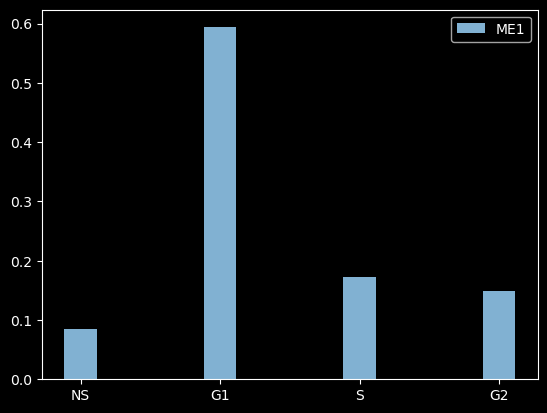

In [11]:
# Define the labels and the width of the bars
ME1_0415.get_volumes()
labels = ['NS', 'G1', 'S', 'G2']
width = 0.35

# Define the x values for the bars
x = np.arange(len(labels))

# Create the bars
plt.bar(x, [len(v)/len(np.concatenate(ME1_0415.volumes)) for v in ME1_0415.volumes], width*2/3, label='ME1', color='C4')

plt.legend()

# Set the x-ticks and the x-tick labels
plt.xticks(x, labels)
plt.show()

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

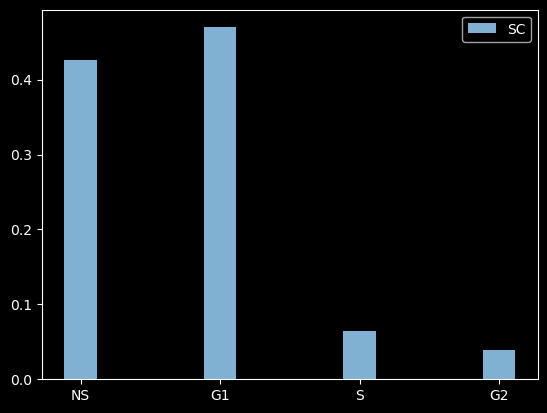

In [152]:
# Define the labels and the width of the bars
Heather_SC.get_volumes()
labels = ['NS', 'G1', 'S', 'G2']
width = 0.35

# Define the x values for the bars
x = np.arange(len(labels))

# Create the bars
plt.bar(x, [len(v)/len(np.concatenate(Heather_SC.volumes)) for v in Heather_SC.volumes], width*2/3, label='SC', color='C4')

plt.legend()

# Set the x-ticks and the x-tick labels
plt.xticks(x, labels)
plt.show()

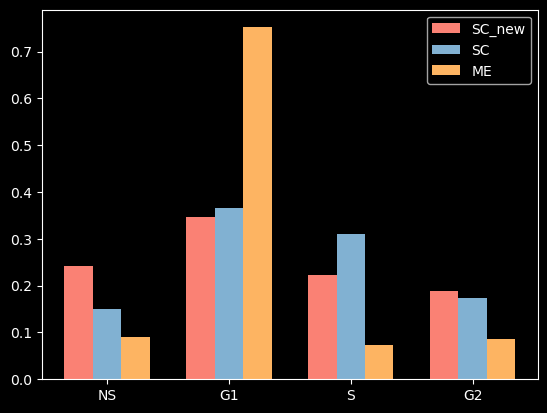

In [123]:
# Define the labels and the width of the bars
labels = ['NS', 'G1', 'S', 'G2']
width = 0.35

# Define the x values for the bars
x = np.arange(len(labels))

# Create the bars
plt.bar(x - width*2/3, [len(v)/len(np.concatenate(SC_new.volumes)) for v in SC_new.volumes], width*2/3, label='SC_new', color='C3')
plt.bar(x, [len(v)/len(np.concatenate(SC.volumes)) for v in SC.volumes], width*2/3, label='SC', color='C4')
plt.bar(x + width*2/3, [len(v)/len(np.concatenate(ME.volumes)) for v in ME.volumes], width*2/3, label='ME', color='C5')

plt.legend()

# Set the x-ticks and the x-tick labels
plt.xticks(x, labels)
plt.show()

In [69]:
SC_0411.get_volumes()

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

[array([2709.56387574, 2433.17387098, 3130.85575723, ..., 2522.66341401,
        1309.1885257 , 1352.65739938]),
 array([2088.66617364, 1699.21507358, 2821.17861269, ..., 1336.10126606,
        1367.84868052, 2107.25038221]),
 array([3693.96428002, 3765.25499293, 3351.16253275, ..., 1763.32250479,
        2192.39321372, 1615.42051883]),
 array([3323.92359854, 4576.327882  , 3117.8863539 , ..., 3029.00494991,
        2032.42660939, 2828.70327332])]

In [82]:
ME_0412.get_volumes()

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

[array([2207.07766566, 2878.57913394, 2562.51128631, ..., 1537.33028616,
        2104.35590243, 1394.25376535]),
 array([3128.02453887, 1617.88155883, 1618.26029119, ..., 1415.3900041 ,
        1369.46047758, 1071.74021093]),
 array([2441.20545714, 2109.93930065, 3587.01933571, ..., 2325.08119617,
        2845.60102356, 1221.95886736]),
 array([2908.45963461, 2372.250895  , 4446.00072008, 2310.56547498,
        3062.67422468, 3367.10624536, 1812.85390124, 2794.78137245,
        1665.26018205, 2484.1164506 , 2218.21760935, 2995.92501696,
        4121.46009008, 2226.42685814, 3411.68834326, 2157.49255725,
        1529.88979919, 2894.65585391, 3206.90688084, 1959.92287647,
        2219.47991267, 2553.90769455, 2912.83539331, 2182.76123789,
        2376.55468769, 2356.13485137, 2475.38340428, 1358.1911964 ,
        2279.50193245, 2385.60111198, 3053.30920715, 3486.01721934,
        3088.71216635, 1203.8967327 , 3632.29955043, 2285.66092874,
        2457.94809737, 1113.7728184 , 1807.349684

In [12]:
pd.to_pickle(ME1_0415.volumes, r'F:\my_data\Segmentation\20240415 halo FUCCI col_glass ME adhered_suspended\volumes\suspension1.pkl')

In [10]:
pd.to_pickle(ME_0412.volumes, r'F:\my_data\Segmentation\20240412 FUCCI_halo_40x suspension ME\volumes\ME.pkl')
pd.to_pickle(SC_0411.volumes, r'F:\my_data\Segmentation\20240411 FUCCI suspension\volumes\SC.pkl')

In [20]:
Heather_SC.get_volumes()
pd.to_pickle(Heather_SC.volumes, r'F:\Heather\FUCCI\suspended\20240410\volumes\SC.pkl')

Getting outlines:   0%|          | 0/11 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

In [25]:
SC_0407.get_volumes()
pd.to_pickle(SC_0407.volumes, r'F:\my_data\Segmentation\20240407 FUCCI suspension\volumes\SC.pkl')

Getting outlines:   0%|          | 0/525 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

In [18]:
SC_0413.get_volumes()
pd.to_pickle(SC_0413.volumes, r'F:\my_data\Segmentation\20240413 FUCCI halo suspension\volumes\SC.pkl')

ME_0413.get_volumes()
pd.to_pickle(ME_0413.volumes, r'F:\my_data\Segmentation\20240413 FUCCI halo suspension\volumes\ME.pkl')

Getting outlines:   0%|          | 0/700 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

Getting outlines:   0%|          | 0/700 [00:00<?, ?it/s]

C:\Users\Andy\AppData\Local\Temp\ipykernel_19096\2485897937.py:108: RuntimeWarning: invalid value encountered in scalar divide
  return 4*np.pi*polyArea(x,y)/polyPerimeter(x,y)**2


Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

## volume statistics

In [220]:
vol_0412_ME=pd.read_pickle(r'F:\my_data\Segmentation\20240412 FUCCI_halo_40x suspension ME\volumes\ME.pkl')
vol_0411_SC=pd.read_pickle(r'F:\my_data\Segmentation\20240411 FUCCI suspension\volumes\SC.pkl')
vol_0415_ME1=pd.read_pickle(r'F:\my_data\Segmentation\20240415 halo FUCCI col_glass ME adhered_suspended\volumes\suspension1.pkl')
vol_0415_ME2=pd.read_pickle(r'F:\my_data\Segmentation\20240415 halo FUCCI col_glass ME adhered_suspended\volumes\suspension2.pkl')

In [225]:
vol_Heather_SC=pd.read_pickle(r'F:\Heather\FUCCI\suspended\20240410\volumes\SC.pkl')
vol_0407_SC=pd.read_pickle(r'F:\my_data\Segmentation\20240407 FUCCI suspension\volumes\SC.pkl')
vol_0413_SC=pd.read_pickle(r'F:\my_data\Segmentation\20240413 FUCCI halo suspension\volumes\SC.pkl')
vol_0413_ME=pd.read_pickle(r'F:\my_data\Segmentation\20240413 FUCCI halo suspension\volumes\ME.pkl')

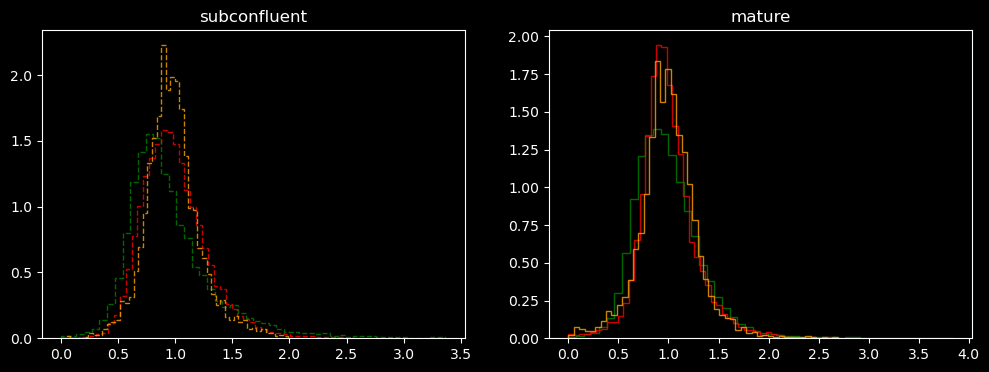

In [245]:
colors=['g','r','orange']
all_ME=[np.concatenate([v1,v2]) for v1, v2 in zip(vol_0412_ME, vol_0415_ME2)]
all_SC=[np.concatenate([v1,v2]) for v1, v2 in zip(vol_0411_SC, vol_0407_SC)]

fig, axes=plt.subplots(1,2,figsize=(12,4))

axes[0].set_title('subconfluent')
axes[1].set_title('mature')

for i, data in enumerate(all_SC[1:]):
    axes[0].hist(data/np.mean(data), bins=50, range=(0,6000/np.mean(data)), density=True, linestyle='--', alpha=0.8, histtype='step', color=colors[i])
for i, data in enumerate(all_ME[1:]):
    axes[1].hist(data/np.mean(data), bins=50, range=(0,6000/np.mean(data)), density=True, alpha=0.8, histtype='step', color=colors[i])

Text(0.5, 1.0, 'suspended cell volumes at SC and ME')

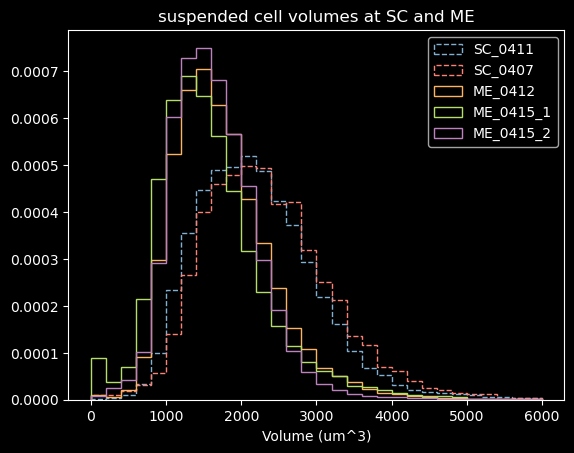

In [271]:
plt.hist(np.concatenate(vol_0411_SC[1:]), bins=30, range=(0,6000), density=True, histtype='step', linestyle='--', label='SC_0411', color='C4')
plt.hist(np.concatenate(vol_0407_SC[1:]), bins=30, range=(0,6000), density=True, histtype='step', linestyle='--', label='SC_0407', color='C3')
#plt.hist(np.concatenate(vol_0413_SC[1:]), bins=30, range=(0,6000), density=True, histtype='step', linestyle='--', label='SC_0413', color='C2')
#plt.hist(np.concatenate(vol_Heather_SC[1:]), bins=30, range=(0,6000), density=True, histtype='step', linestyle='--', label='Heather_SC', color='C2')
plt.hist(np.concatenate(vol_0412_ME[1:]), bins=30, range=(0,6000), density=True, histtype='step', label='ME_0412', color='C5')
plt.hist(np.concatenate(vol_0415_ME1[1:]), bins=30, range=(0,6000), density=True, histtype='step', label='ME_0415_1', color='C6')
plt.hist(np.concatenate(vol_0415_ME2[1:]), bins=30, range=(0,6000), density=True, histtype='step', label='ME_0415_2', color='C7')
#plt.hist(np.concatenate(vol_0413_ME[1:]), bins=30, range=(0,6000), density=True, histtype='step', label='ME_0413', color='C8')

plt.legend()

plt.xlabel('Volume (um^3)')
plt.title('suspended cell volumes at SC and ME')

#plt.savefig('plots/suspended_volumes/volume_hist.jpg', dpi=300)

Text(0.5, 0, 'volume/<volume>')

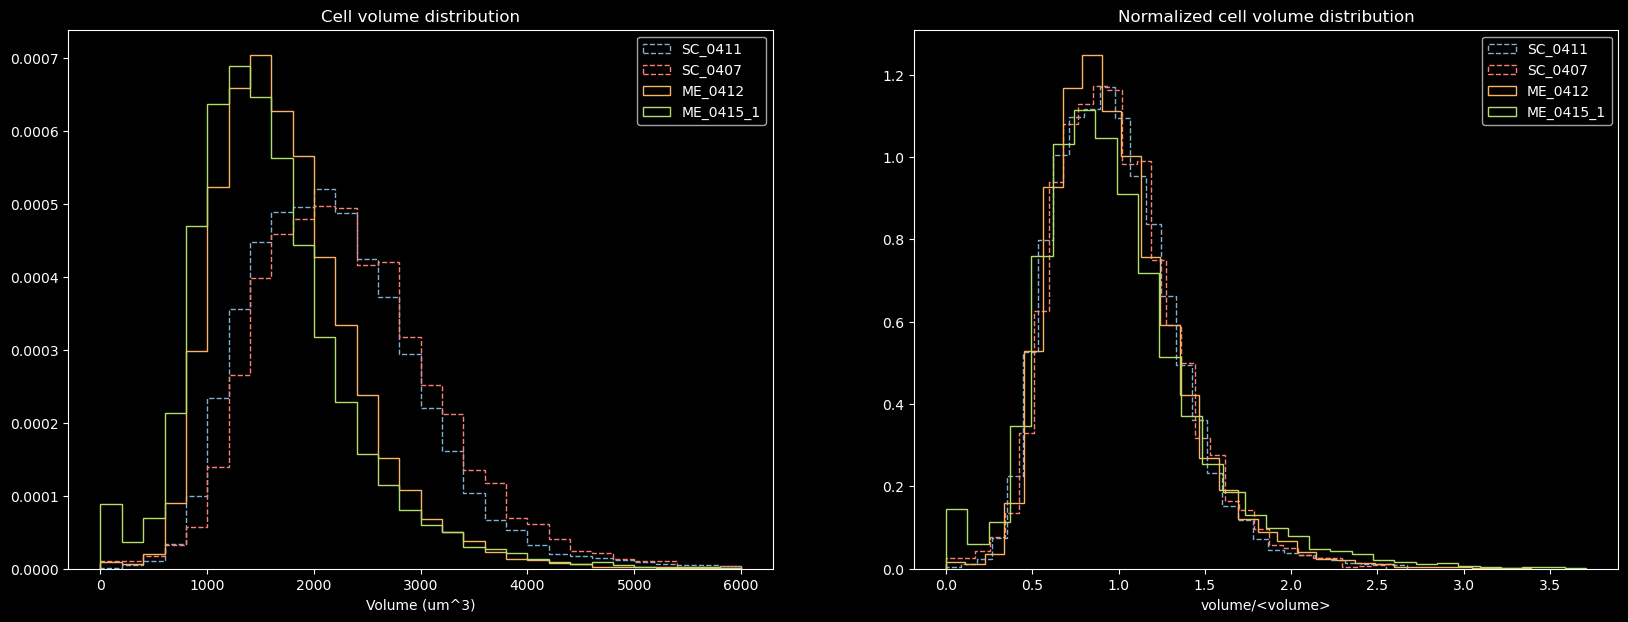

In [35]:
def volume_hist(volumes, ax, normalize=False, label=None, bins=30, range=(0,6000), density=True, histtype='step', **kwargs):
    volumes=np.concatenate(volumes)
    if normalize:
        range=(0, range[1]/np.mean(volumes))
        volumes/=np.mean(volumes)

    if label is not None and label.startswith('SC'):
        linestyle='--'
    else:
        linestyle='-'

    ax.hist(volumes, bins=bins, range=range, density=density, label=label, linestyle=linestyle, histtype=histtype, **kwargs)

fig, axes=plt.subplots(1,2, figsize=(20,7))

volume_hist(vol_0411_SC[1:], axes[0], label='SC_0411', color='C4')
volume_hist(vol_0407_SC[1:], axes[0], label='SC_0407', color='C3')
volume_hist(vol_0412_ME[1:], axes[0], label='ME_0412', color='C5')
volume_hist(vol_0415_ME1[1:], axes[0], label='ME_0415_1', color='C6')

volume_hist(vol_0411_SC[1:], axes[1], label='SC_0411', color='C4', normalize=True)
volume_hist(vol_0407_SC[1:], axes[1], label='SC_0407', color='C3', normalize=True)
volume_hist(vol_0412_ME[1:], axes[1], label='ME_0412', color='C5', normalize=True)
volume_hist(vol_0415_ME1[1:], axes[1], label='ME_0415_1', color='C6', normalize=True)

axes[0].legend()
axes[1].legend()

axes[0].set_title('Cell volume distribution')
axes[1].set_title('Normalized cell volume distribution')

axes[0].set_xlabel('Volume (um^3)')
axes[1].set_xlabel('volume/<volume>')

Text(0.5, 1.0, 'G2')

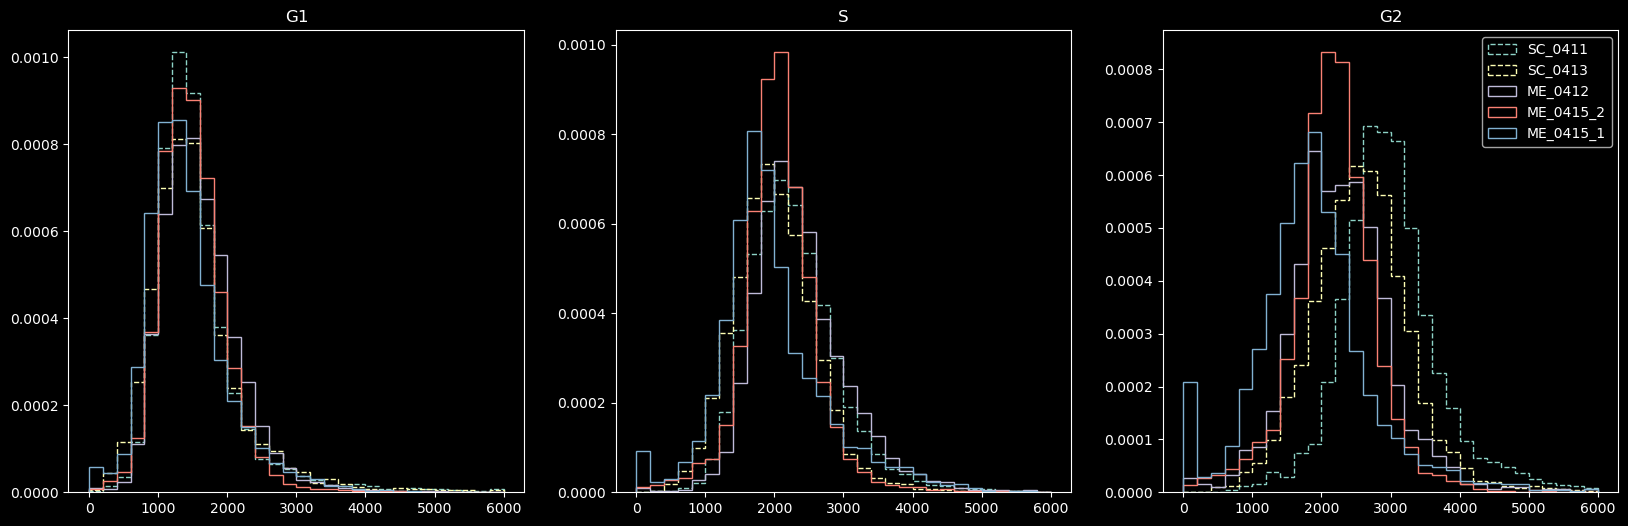

In [273]:
fig, axes=plt.subplots(1,3, figsize=(20,6))

for vol,label in zip([vol_0411_SC, vol_0413_SC,vol_0412_ME, vol_0415_ME2, vol_0415_ME1], ['SC_0411', 'SC_0413', 'ME_0412', 'ME_0415_2', 'ME_0415_1']):
    if label.startswith('SC'):
        linestyle='--'
    else:
        linestyle='-'
    for ax, v in zip(axes, vol[1:]):
        ax.hist(v, bins=30, range=(0,6000), density=True, histtype='step', linestyle=linestyle, label=label)

axes[2].legend()
axes[0].set_title('G1')
axes[1].set_title('S')
axes[2].set_title('G2')

In [124]:
# bar plots of cell cycle stage distributions
def cc_occupancy(vol):
    return [len(v)/len(np.concatenate(vol)) for v in vol]

def multi_barplot(vols, labels, ax=None, hatching=False):
    if not ax:
        ax=plt.gca()
        
    num_groups=len(vols)
    width=1/(num_groups+1)

    x=np.arange(4)
    for i, vol in enumerate(vols):
        if hatching:
            if labels[i].startswith('SC'):
                hatching='ooo'
            else:
                hatching='///'
        else:
            hatching=None

        ax.bar(x+i*width, cc_occupancy(vol), width, align='edge', edgecolor='k', hatch=hatching, label=labels[i])
    
    plt.xticks(x+width*num_groups/2, ['NS', 'G1', 'S', 'G2']) # centered labels
    plt.legend()

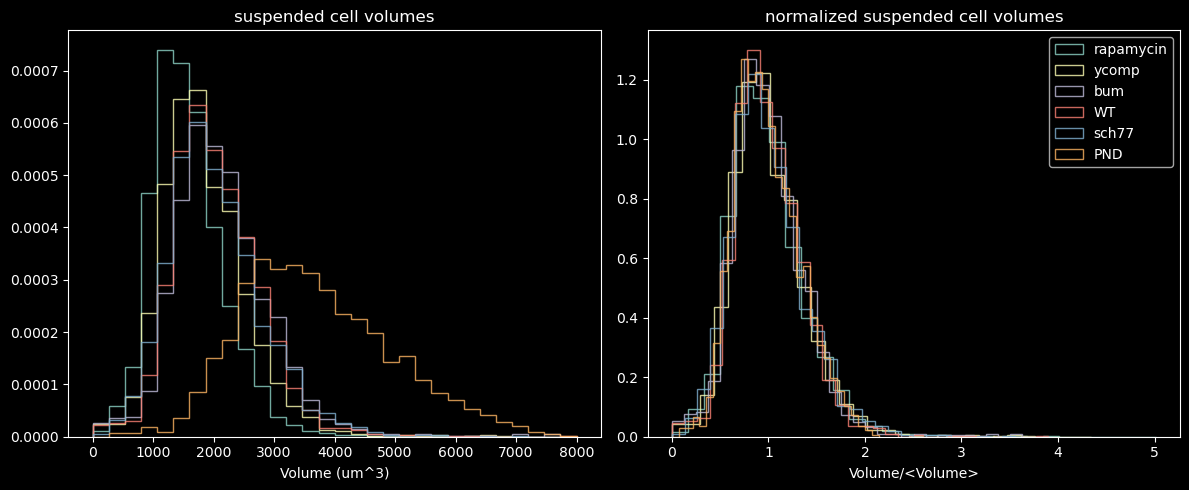

In [219]:
fig, axes=plt.subplots(1,2, figsize=(12,5))

for dataset, label in zip([rapamycin_vols, ycomp_vols, bum1_vols, WT_vols, sch77_vols, PND_vols], ['rapamycin', 'ycomp', 'bum', 'WT', 'sch77', 'PND']):
    axes[0].hist(np.concatenate(dataset[1:]), range=(0,8000), bins=30, density=True, histtype='step', alpha=0.8, label=label)
    axes[1].hist(np.concatenate(dataset[1:])/np.mean(np.concatenate(dataset[1:])), range=(0,8000/np.mean(np.concatenate(dataset[1:]))), bins=30, density=True, histtype='step', alpha=0.8, label=label)

axes[1].legend()
axes[0].set_xlabel('Volume (um^3)')
axes[1].set_xlabel('Volume/<Volume>')
axes[0].set_title('suspended cell volumes')
axes[1].set_title('normalized suspended cell volumes')

fig.tight_layout()
plt.savefig(r'F:\Heather\FUCCI\suspended\20240419\plots\volume_hist.jpg', bbox_inches='tight', dpi=300)

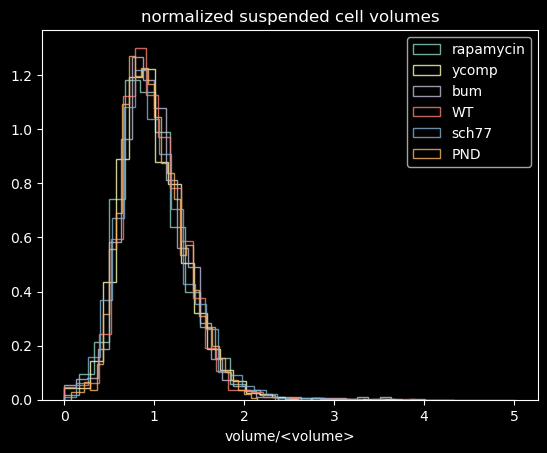

In [215]:
for dataset, label in zip([rapamycin_vols, ycomp_vols, bum1_vols, WT_vols, sch77_vols, PND_vols], ['rapamycin', 'ycomp', 'bum', 'WT', 'sch77', 'PND']):
    plt.hist(np.concatenate(dataset[1:])/np.mean(np.concatenate(dataset[1:])), range=(0,8000/np.mean(np.concatenate(dataset[1:]))), bins=30, density=True, histtype='step', alpha=0.8, label=label)

plt.legend()
plt.xlabel('volume/<volume>')
plt.title('normalized suspended cell volumes')

plt.savefig(r'F:\Heather\FUCCI\suspended\20240419\plots\normalized_volume_hist.jpg', bbox_inches='tight', dpi=300)

(array([[3.78787879e-05, 2.36742424e-05, 5.68181818e-05, 2.55681818e-04,
         6.77083333e-04, 1.09375000e-03, 8.57007576e-04, 4.26136364e-04,
         1.56250000e-04, 4.73484848e-05, 4.26136364e-05, 1.42045455e-05,
         9.46969697e-06, 1.42045455e-05, 9.46969697e-06, 4.73484848e-06,
         4.73484848e-06, 0.00000000e+00, 0.00000000e+00, 4.73484848e-06,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.73484848e-06,
         4.73484848e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 4.73484848e-06],
        [1.69071235e-05, 2.70513977e-05, 1.69071235e-05, 4.05770965e-05,
         7.43913436e-05, 2.84039675e-04, 5.88367899e-04, 6.86429216e-04,
         7.30387737e-04, 5.03832281e-04, 3.61812444e-04, 2.23174031e-04,
         1.01442741e-04, 5.41027953e-05, 1.01442741e-05, 1.35256988e-05,
         6.76284941e-06, 6.76284941e-06, 0.00000000e+00, 3.38142471e-06,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         

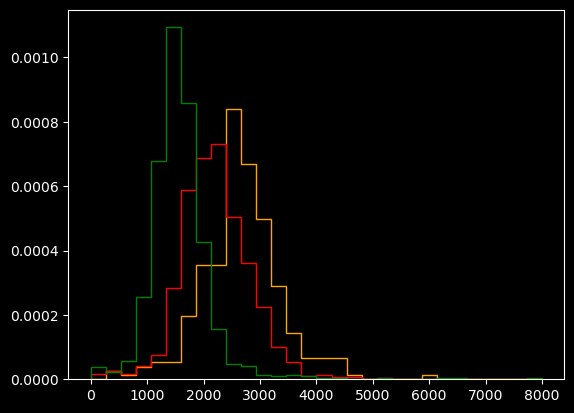

In [184]:
plt.hist(WT_vols[1:], histtype='step', range=(0,8000), bins=30, density=True, color=['g','r','orange'])

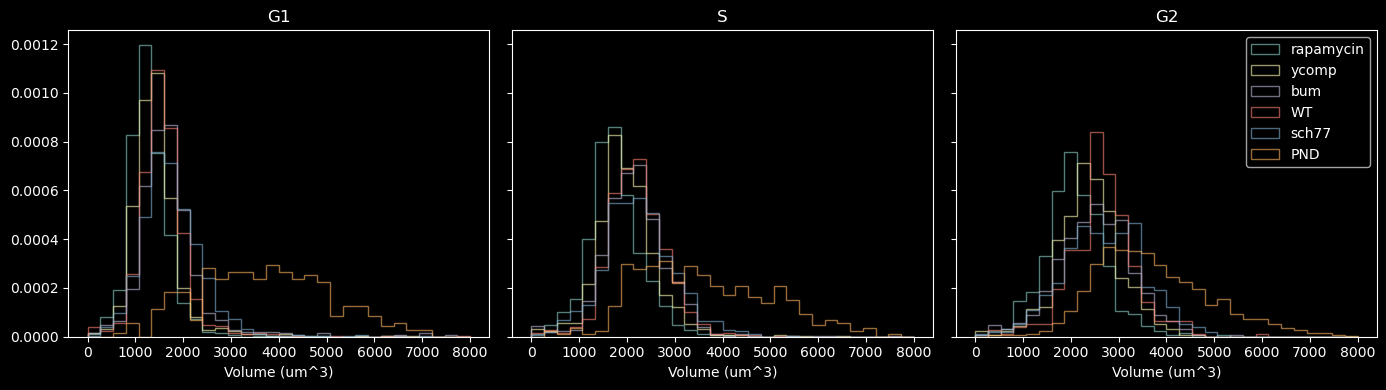

In [206]:
fig, axes=plt.subplots(1,3, figsize=(14,4), sharex=True, sharey=True)
for dataset, label in zip([rapamycin_vols, ycomp_vols, bum1_vols, WT_vols, sch77_vols, PND_vols], ['rapamycin', 'ycomp', 'bum', 'WT', 'sch77', 'PND']):
    for ax, data in zip(axes, dataset[1:]):
        ax.hist(data, range=(0,8000), bins=30, density=True, histtype='step', alpha=0.6, label=label)

for ax, title in zip(axes, ['G1','S','G2']):
    ax.set_title(title)
    ax.set_xlabel('Volume (um^3)')
    
axes[2].legend()
fig.tight_layout()

plt.savefig(r'F:\Heather\FUCCI\suspended\20240419\plots\cc_volume_hist.jpg', bbox_inches='tight', dpi=300)

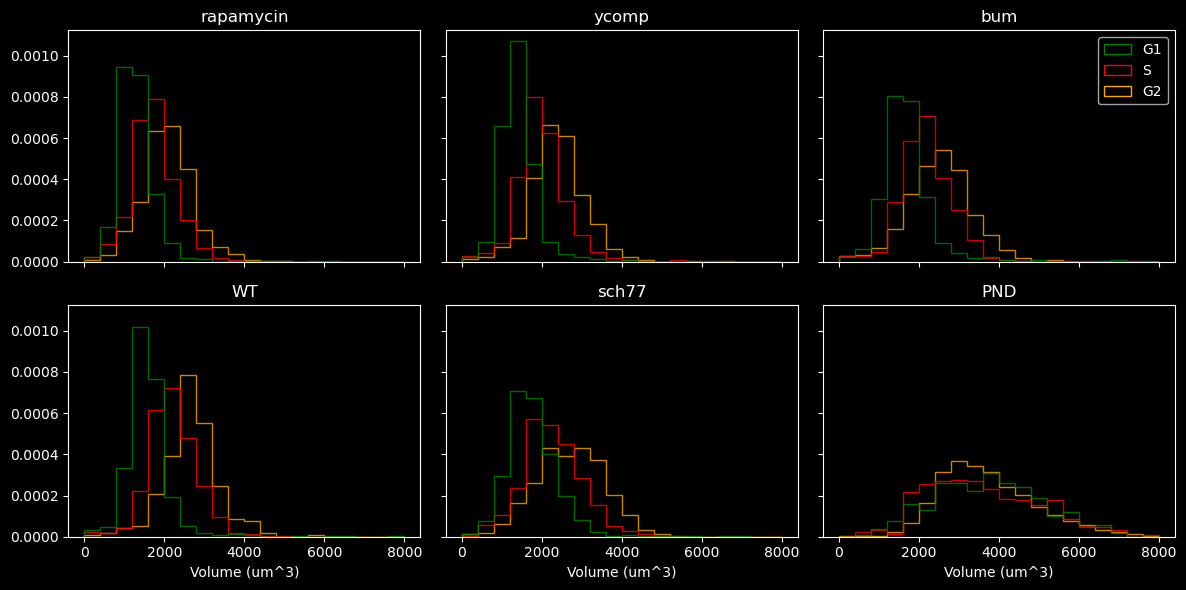

In [209]:
fig, axes=plt.subplots(2,3, figsize=(12,6), sharex=True, sharey=True)
for dataset, label, ax in zip([rapamycin_vols, ycomp_vols, bum1_vols, WT_vols, sch77_vols, PND_vols], ['rapamycin', 'ycomp', 'bum', 'WT', 'sch77', 'PND'], axes.flatten()):
    ax.hist(dataset[1:], range=(0,8000), bins=20, density=True, histtype='step', alpha=0.8, color=['g','r','orange'])
    ax.set_title(label)

for ax in axes[1]:
    ax.set_xlabel('Volume (um^3)')

axes[0,2].bar(0,0, color='k', ec='g', label='G1')
axes[0,2].bar(0,0, color='k', ec='r', label='S')
axes[0,2].bar(0,0, color='k', ec='orange', label='G2')
axes[0,2].legend()

fig.tight_layout()
plt.savefig(r'F:\Heather\FUCCI\suspended\20240419\plots\treatment_volume_hist.jpg', bbox_inches='tight', dpi=300)

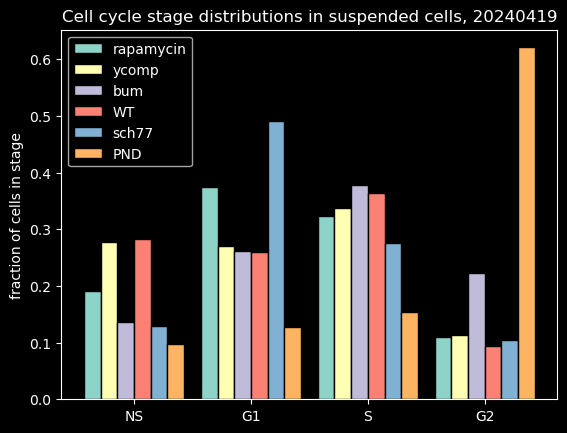

In [177]:
multi_barplot([rapamycin_vols, ycomp_vols, bum1_vols, WT_vols, sch77_vols, PND_vols], ['rapamycin', 'ycomp', 'bum', 'WT', 'sch77', 'PND'])
plt.ylabel('fraction of cells in stage')
plt.title('Cell cycle stage distributions in suspended cells, 20240419')
plt.savefig(r'F:\Heather\FUCCI\suspended\20240419\cc_occupancy.jpg', bbox_inches='tight', dpi=300)

In [154]:
def volume_boxplot(vols, labels, ax=None):
    if not ax:
        ax=plt.gca()
    num_groups=len(vols)
    colors=['k','g','r','orange']
    
    for i, vol in enumerate(vols):
        n_samples=[len(v) for v in vol]
        box_labels=[f"{labels[i]}\n n={n}" for n in n_samples]
        bp=ax.boxplot(vol, positions=np.arange(i*5, i*5+4), patch_artist=True, showfliers=False, labels=box_labels)

        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            
    plt.xticks(rotation=45)
    ax.set_ylabel('volume (um^3)')

In [173]:
print([np.median(v[1]) for v in [WT_vols, bum1_vols, PND_vols, rapamycin_vols, sch77_vols, ycomp_vols]])

[1535.7936735737649, 1621.9007515029643, 3708.870177807065, 1229.5938774046228, 1691.904944629163, 1381.5072970510257]


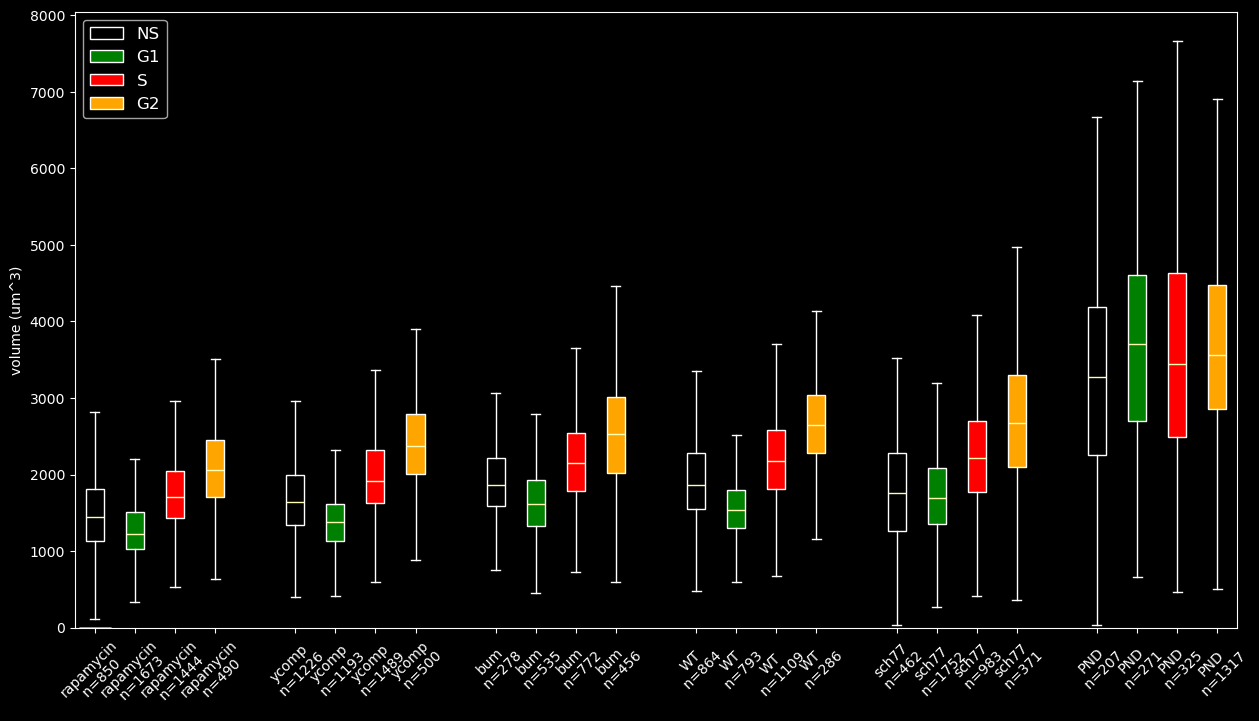

In [176]:
plt.figure(figsize=(15,8))
volume_boxplot([rapamycin_vols, ycomp_vols, bum1_vols, WT_vols, sch77_vols, PND_vols], ['rapamycin', 'ycomp', 'bum', 'WT', 'sch77', 'PND'])
# fake legend with NS, G1, S, G2
plt.bar(0,0, color='k', ec='white', label='NS')
plt.bar(0,0, color='g', ec='white', label='G1')
plt.bar(0,0, color='r', ec='white', label='S')
plt.bar(0,0, color='orange', ec='white', label='G2')
plt.legend(fontsize=12)

plt.savefig(r'F:\Heather\FUCCI\suspended\20240419\plots\volume_boxplot.jpg', bbox_inches='tight', dpi=300)

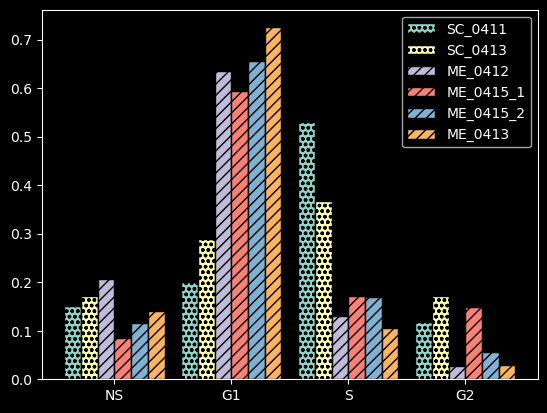

In [23]:
multi_barplot([vol_0411_SC, vol_0413_SC, vol_0412_ME, vol_0415_ME1, vol_0415_ME2, vol_0413_ME], ['SC_0411','SC_0413','ME_0412','ME_0415_1', 'ME_0415_2', 'ME_0413'], plt.gca())

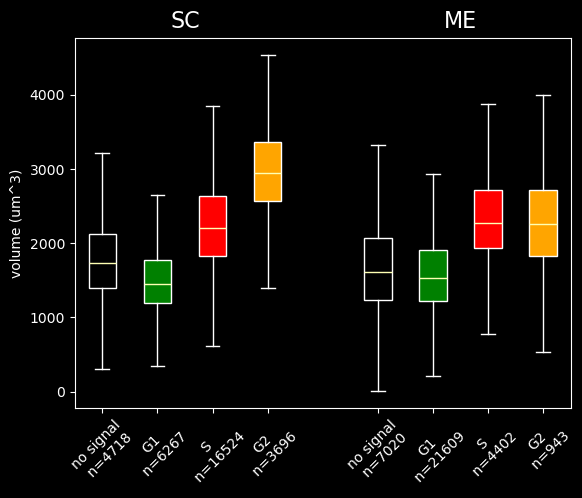

In [132]:
volumes=SC_0411.volumes+ME_0412.volumes
names=['no signal', 'G1', 'S', 'G2']*2
n_samples=[len(v) for v in volumes]

labels=[f"{name}\n n={n}" for name, n in zip(names, n_samples)]
colors=['k','g','r','orange']*2
bp=plt.boxplot(volumes, positions=[1,2,3,4,6,7,8,9],patch_artist=True, showfliers=False, labels=labels)
plt.xticks(rotation=45)
plt.ylabel('volume (um^3)')

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# label first group as subconfluent, second group as mature
plt.text(2.5, 4900, 'SC', fontsize=16, ha='center')
plt.text(7.5, 4900, 'ME', fontsize=16, ha='center')

fig.tight_layout()
#plt.savefig('plots/suspended_volumes/20240412 suspended volumes.jpg', bbox_inches='tight',dpi=300)

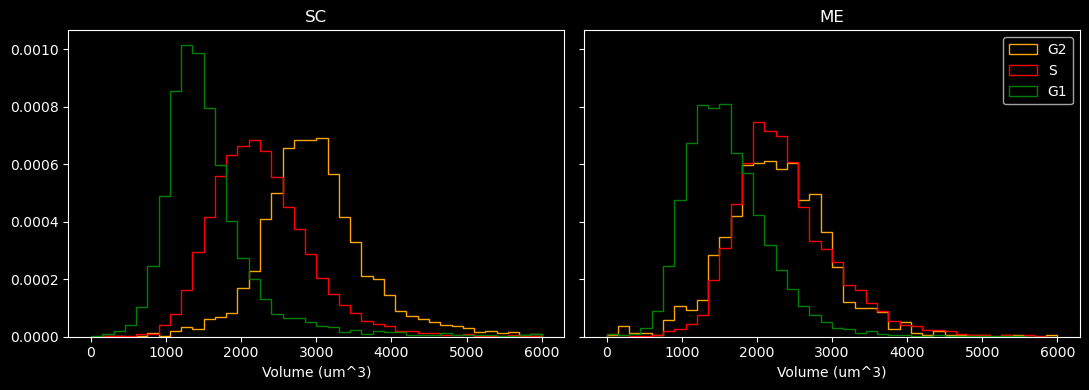

In [123]:
fig, axes=plt.subplots(1,2, figsize=(11,4), sharey=True)
axes[0].hist(SC_0411.volumes[1:], bins=40, range=(0,6000), density=True, histtype='step', label=['G1', 'S', 'G2'], color=['g','r','orange'])
axes[1].hist(ME_0412.volumes[1:], bins=40, range=(0,6000), density=True, histtype='step', label=['G1', 'S', 'G2'], color=['g','r','orange'])

axes[1].legend()

axes[0].set_title('SC')
axes[1].set_title('ME')

axes[0].set_xlabel('Volume (um^3)')
axes[1].set_xlabel('Volume (um^3)')
fig.tight_layout()

plt.savefig('plots/suspended_volumes/FUCCI_volume_hist.jpg', dpi=300)

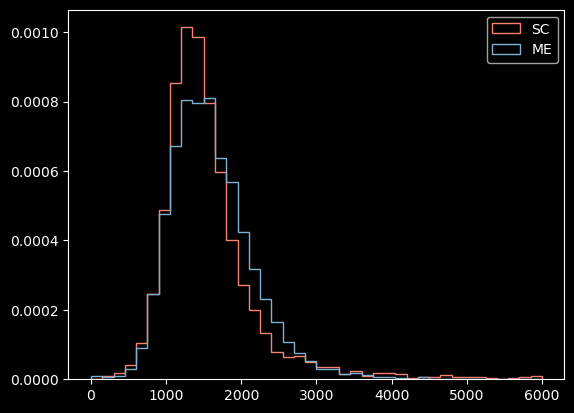

In [90]:
plt.hist(SC_0411.volumes[1], bins=40, range=(0,6000), density=True, histtype='step', label='SC', color='C3')
plt.hist(ME_0412.volumes[1], bins=40, range=(0,6000), density=True, histtype='step', label='ME', color='C4')
plt.legend()

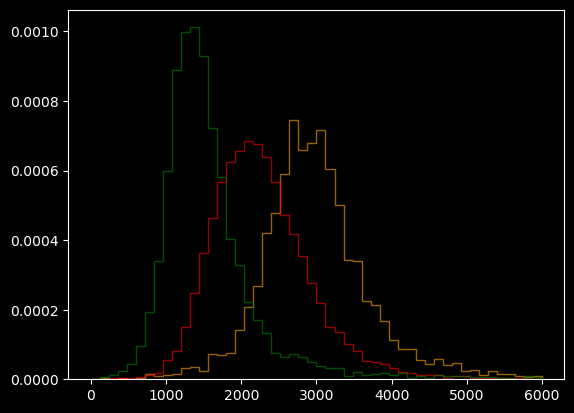

In [72]:
plt.hist(SC_0411.volumes[1:], color=['g','r','orange'], alpha=0.6, bins=50, range=(0,6000), density=True, histtype='step')
plt.show()

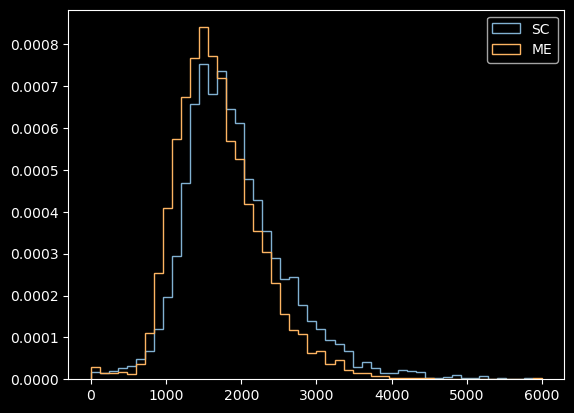

In [68]:
# plot G1 volumes for ME and SC as histograms
plt.hist(SC.volumes[1], bins=50, range=(0,6000), density=True, histtype='step', label='SC', color='C4')
plt.hist(ME.volumes[1], bins=50, range=(0,6000), density=True, histtype='step', label='ME', color='C5')

plt.legend()